<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Gated Response Unit (GRU)

###Install dependencies

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00


###Load Libraries

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout, GRU
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [4]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [5]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [6]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [7]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

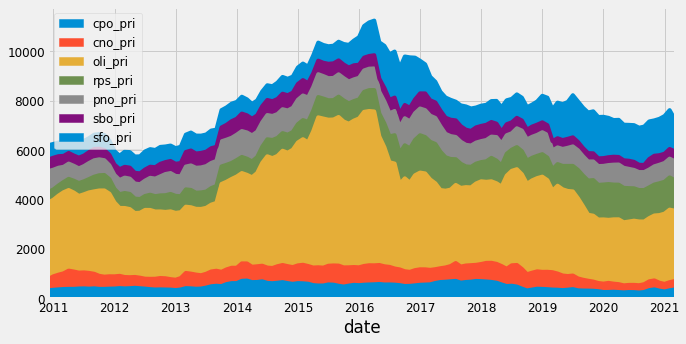

In [8]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Gated Response Unit Forecasting Technique (GRU)**

###**Split Data into Train Test Segments**

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [10]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [11]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [12]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [13]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [14]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [15]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [16]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [17]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [19]:
import tensorflow as tf
tf.random.set_seed(1)

#The GRU architecture
GRU_model = tf.keras.Sequential()
# First GRU layer
GRU_model.add(tf.keras.layers.GRU(75, return_sequences=True,activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
GRU_model.add(Dropout(0.2))

# Second GRU layer
GRU_model.add(tf.keras.layers.GRU(64, return_sequences=True))
GRU_model.add(Dropout(0.2))

# Third GRU layer
GRU_model.add(tf.keras.layers.GRU(64))
GRU_model.add(Dropout(0.2))

#The output layer
GRU_model.add(tf.keras.layers.Dense(units=1))

# compiling the GRU network
GRU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse',metrics=['mse'])

# model training
history = GRU_model.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
GRU_model.evaluate(X_test, y_test)

Epoch 1/100
2/2 [==============================] - 9s 2s/step - loss: 0.2224 - mse: 0.2224 - val_loss: 0.2435 - val_mse: 0.2435
Epoch 2/100
2/2 [==============================] - 0s 73ms/step - loss: 0.1289 - mse: 0.1289 - val_loss: 0.2187 - val_mse: 0.2187
Epoch 3/100
2/2 [==============================] - 0s 74ms/step - loss: 0.0950 - mse: 0.0950 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 4/100
2/2 [==============================] - 0s 90ms/step - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0689 - val_mse: 0.0689
Epoch 5/100
2/2 [==============================] - 0s 79ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.1116 - val_mse: 0.1116
Epoch 6/100
2/2 [==============================] - 0s 63ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 7/100
2/2 [==============================] - 0s 63ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 8/100
2/2 [==============================] - 0s 50ms/step - loss: 0.0379 - mse: 0.0379

[0.011426705867052078, 0.011426705867052078]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


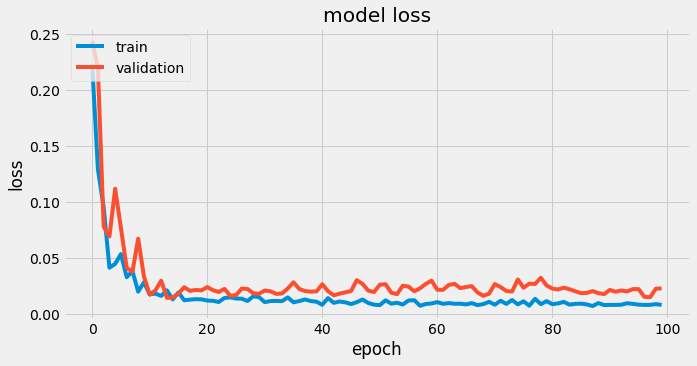

In [20]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
mse_GRU = GRU_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 42ms/step - loss: 0.0114 - mse: 0.0114


####Baseline MSE = 0.01660

In [22]:
GRU_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 3, 75)             18900     
                                                                 
 dropout_3 (Dropout)         (None, 3, 75)             0         
                                                                 
 gru_4 (GRU)                 (None, 3, 64)             27072     
                                                                 
 dropout_4 (Dropout)         (None, 3, 64)             0         
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

###Predict the Test without Hyperparameter Tuning

In [23]:
y_pred = GRU_model.predict(X_test)
y_pred

1/1 [==============================] - 1s 1s/step


array([[ 0.1301786 ],
       [ 0.11324514],
       [ 0.12520711],
       [ 0.10698395],
       [ 0.05941937],
       [ 0.00640428],
       [-0.03290395],
       [-0.09258106],
       [-0.16515332],
       [-0.20511323],
       [-0.20345753],
       [-0.19318244],
       [-0.20826879],
       [-0.2073111 ],
       [-0.21713528],
       [-0.25842324],
       [-0.26427534],
       [-0.1397013 ],
       [-0.00659293],
       [ 0.01241878],
       [-0.04996869],
       [-0.05187383]], dtype=float32)

In [24]:
y_pred.reshape(1,-1)

array([[ 0.1301786 ,  0.11324514,  0.12520711,  0.10698395,  0.05941937,
         0.00640428, -0.03290395, -0.09258106, -0.16515332, -0.20511323,
        -0.20345753, -0.19318244, -0.20826879, -0.2073111 , -0.21713528,
        -0.25842324, -0.26427534, -0.1397013 , -0.00659293,  0.01241878,
        -0.04996869, -0.05187383]], dtype=float32)

###Invert Transformed Data

In [26]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[371.07144 364.29807 369.08286 361.79358 342.76773 321.5617  305.8384
  281.96756 252.93867 236.95471 237.61699 241.72702 235.69247 236.07556
  232.14587 215.63069 213.28986 263.11948 316.36282 323.9675  299.0125
  298.25046]]


###Plot History, Actual and Predicted Value

In [27]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [28]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [29]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([371.07144, 364.29807, 369.08286, 361.79358, 342.76773, 321.5617 ,
       305.8384 , 281.96756, 252.93867, 236.95471, 237.61699, 241.72702,
       235.69247, 236.07556, 232.14587, 215.63069, 213.28986, 263.11948,
       316.36282, 323.9675 , 299.0125 , 298.25046], dtype=float32)

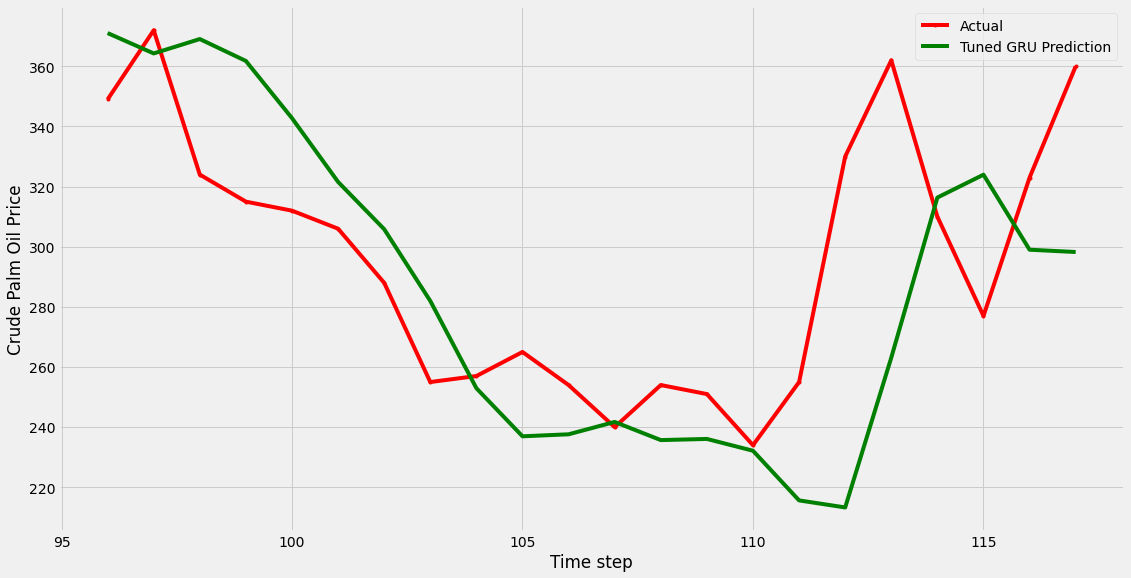

In [30]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="Tuned GRU Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

###Evaluating GRU Model Performance

In [32]:
MAE_GRU = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the GRU Model is:', MAE_GRU)

MDA_GRU = mda(y_test_inv, y_pred_inv)
print('MDA value of the GRU Model is:', MDA_GRU)

MAPE_GRU = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the GRU Model is:', MAPE_GRU)

RMSE_GRU = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the GRU Model is:', RMSE_GRU)

MSE_GRU = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the GRU Model is:', MSE_GRU)

#EVS_GRU = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the GRU Model is:', EVS_GRU)

MAE value of the GRU Model is: 31.45978546142578
MDA value of the GRU Model is: 0.3333333333333333
MAPE value of the GRU Model is: 10.175806195113097
RMSE value of the GRU Model is: 42.75830848637212
MSE value of the GRU Model is: 1828.2729446157623


###Tuning GRU with Keras Tuner

Define A Model-Building Class

In [33]:
class GRUhypermodel(HyperModel):
#class GRUHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
      
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, activation='tanh', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        Kernel_initializer = hp.Choice('kernel_initializer', values= ['Kernel_initializer', 'lecun_uniform', 'zero', 'ones', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform', 'uniform', 'normal', 'orthogonal', 'constant', 'random_normal', 'random_uniform'])
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

hypermodel= GRUhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
#hypermodel = GRUHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [34]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [36]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [37]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 400ms/step - loss: 0.4318 - mae: 0.6480 - mse: 0.4318


####Random Search MSE = 0.4318

In [38]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 96,
 'units_3': 64,
 'units_4': 24,
 'dropout': 0.0,
 'kernel_initializer': 'zero',
 'optimizer': 'rmsprop',
 'activation': 'ELU',
 'batch_size': 56,
 'epoch': 60,
 'momentum': 0.9700000000000001,
 'decay': 0.00040000100000000003,
 'learning_rate': 0.005507461185174967}

###Build Bayesian Optimization

In [39]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [40]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 407ms/step - loss: 0.2356 - mae: 0.4716 - mse: 0.2356


###Bayesian Optimization Search MSE = 0.2356

###Evaluate Bayesian Optimization

In [41]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 64,
 'units_3': 48,
 'units_4': 32,
 'dropout': 0.05,
 'kernel_initializer': 'constant',
 'optimizer': 'adam',
 'activation': 'sigmoid',
 'batch_size': 8,
 'epoch': 25,
 'momentum': 0.81,
 'decay': 0.00040000100000000003,
 'learning_rate': 0.006678619769811224}

In [42]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 1s 684ms/step - loss: 0.2356 - mae: 0.4716 - mse: 0.2356


###Build HYPERBAND optimization

In [43]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [44]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [45]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


1711.4100823402405  secs


In [46]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
fourth layer is {best_hps.get('units_4')}
drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 96 
third layer is 48 
fourth layer is 32
drop out is 0.1
batch_size is 16
epoch is 100
optimizer is adagrad
activation is relu

momentum is 0.8
decay is 0.000200001

#learning rate is 0.005697142087257759                                        

and the optimal learning rate for the optimizer
is 0.005697142087257759.

[]
1/1 [==============================] - 0s 493ms/step - loss: 0.0116 - mae: 0.0947 - mse: 0.0116
loss:0.011553892865777016 mae: 0.09474045783281326 mse: 0.011553892865777016


In [47]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 128, 'units_2': 96, 'units_3': 48, 'units_4': 32, 'dropout': 0.1, 'kernel_initializer': 'random_normal', 'optimizer': 'adagrad', 'activation': 'relu', 'batch_size': 16, 'epoch': 100, 'momentum': 0.8, 'decay': 0.000200001, 'learning_rate': 0.005697142087257759, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0215'}


###Apply the trained parameters to the GRU

In [104]:
import tensorflow as tf
tf.random.set_seed(1)

#The TUGRU architecture
TUGRU_model = tf.keras.Sequential()
# First GRU layer
TUGRU_model.add(tf.keras.layers.GRU(128, return_sequences=True,activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
TUGRU_model.add(tf.keras.layers.GRU(96, return_sequences=True))
TUGRU_model.add(Dropout(0.1))

# Second TUGRU layer
#TUGRU_model.add(tf.keras.layers.GRU(96, activation='relu', return_sequences=True))
TUGRU_model.add(Dropout(0.1))

# Third TUGRU layer
TUGRU_model.add(tf.keras.layers.GRU(46))
TUGRU_model.add(Dropout(0.1))

# Fourth TUGRU layer
#TUGRU_model.add(tf.keras.layers.GRU(32, activation='relu'))
#TUGRU_model.add(Dropout(0.1))

#The output layer
GRU_model.add(tf.keras.layers.Dense(1))

In [105]:
TUGRU_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.00010), metrics= ['mae', 'mse'])
#TUGRU_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),
history = TUGRU_model.fit(X_train, y_train, epochs=100, batch_size=16,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/100
5/5 [==============================] - 7s 272ms/step - loss: 0.2904 - mae: 0.4695 - mse: 0.2904 - val_loss: 0.4518 - val_mae: 0.5793 - val_mse: 0.4518
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 0.2900 - mae: 0.4692 - mse: 0.2900 - val_loss: 0.4518 - val_mae: 0.5792 - val_mse: 0.4518
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 0.2904 - mae: 0.4694 - mse: 0.2904 - val_loss: 0.4517 - val_mae: 0.5792 - val_mse: 0.4517
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 0.2904 - mae: 0.4694 - mse: 0.2904 - val_loss: 0.4517 - val_mae: 0.5791 - val_mse: 0.4517
Epoch 5/100
5/5 [==============================] - 0s 21ms/step - loss: 0.2901 - mae: 0.4692 - mse: 0.2901 - val_loss: 0.4516 - val_mae: 0.5791 - val_mse: 0.4516
Epoch 6/100
5/5 [==============================] - 0s 22ms/step - loss: 0.2900 - mae: 0.4691 - mse: 0.2900 - val_loss: 0.4515 - val_mae: 0.5791 - val_mse: 0.4515
Epoch 7/100
5/5 [==========

Plot Model Loss

<Figure size 720x360 with 0 Axes>

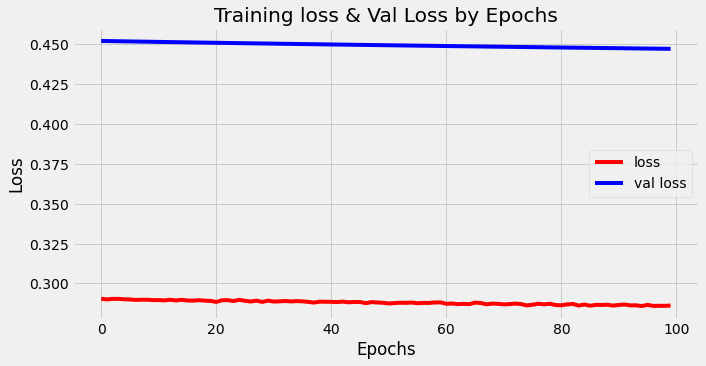

<Figure size 720x360 with 0 Axes>

In [106]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

In [107]:
y_predTU = TUGRU_model.predict(X_test)
y_predTU

1/1 [==============================] - 3s 3s/step


array([[ 0.01096811,  0.01855623,  0.00199695, ..., -0.01446886,
         0.05269959,  0.02961335],
       [ 0.0089967 ,  0.01741239,  0.00406117, ..., -0.01328213,
         0.05121772,  0.02870728],
       [ 0.01036966,  0.01718417,  0.00591581, ..., -0.01219559,
         0.05372265,  0.02838765],
       ...,
       [ 0.01332157,  0.02040021,  0.01048873, ..., -0.00312519,
         0.03747742,  0.01913496],
       [ 0.01480518,  0.01999473,  0.01157657, ..., -0.00279807,
         0.03899818,  0.01869722],
       [ 0.01487106,  0.01949716,  0.01158787, ..., -0.0031056 ,
         0.04278177,  0.01916537]], dtype=float32)

In [108]:
y_predTU.reshape(1,-1)

array([[ 0.01096811,  0.01855623,  0.00199695, ..., -0.0031056 ,
         0.04278177,  0.01916537]], dtype=float32)

###Invert Transformed Tuned Data

In [109]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[323.38724 326.4225  319.79877 ... 317.75775 336.1127  326.66614]]


In [110]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [111]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [112]:
TU_GRU_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_GRU_Pred
TU_GRU_Pred

array([323.38724, 326.4225 , 319.79877, ..., 317.75775, 336.1127 ,
       326.66614], dtype=float32)

ValueError: ignored

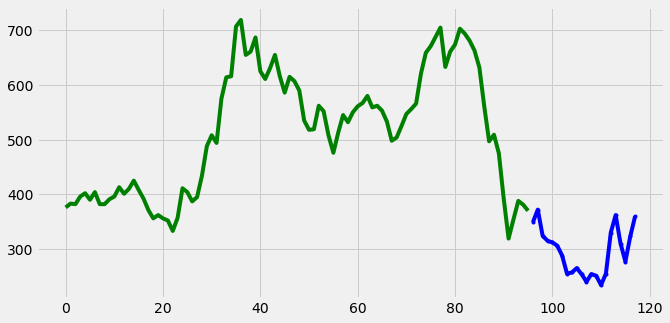

In [113]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_GRU_Pred, color='red', label="Tuned GRU Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

In [82]:
TUMAE_GRU = mean_absolute_error(y_test_inv, TU_GRU_Pred)
print('MAE value of the GRU Model is:', TUMAE_GRU)

TUMDA_GRU = mda(y_test_inv, TU_GRU_Pred)
print('MDA value of the tuned GRU Model is:', TUMDA_GRU)

TUMAPE_GRU = mean_absolute_percentage_error(y_test_inv, TU_GRU_Pred)
print('MAPE value of the tuned GRU Model is:', TUMAPE_GRU)

TURMSE_GRU = mean_squared_error(y_test_inv,TU_GRU_Pred, squared=False)
print('RMSE value of the tuned GRU Model is:', TURMSE_GRU)

TUMSE_GRU = mean_squared_error(y_test_inv,TU_GRU_Pred)
print('MSE value of the tuned GRU Model is:', TUMSE_GRU)

ValueError: ignored

Compare tuned GRU Actual VS Predicted (Zoomed-IN)

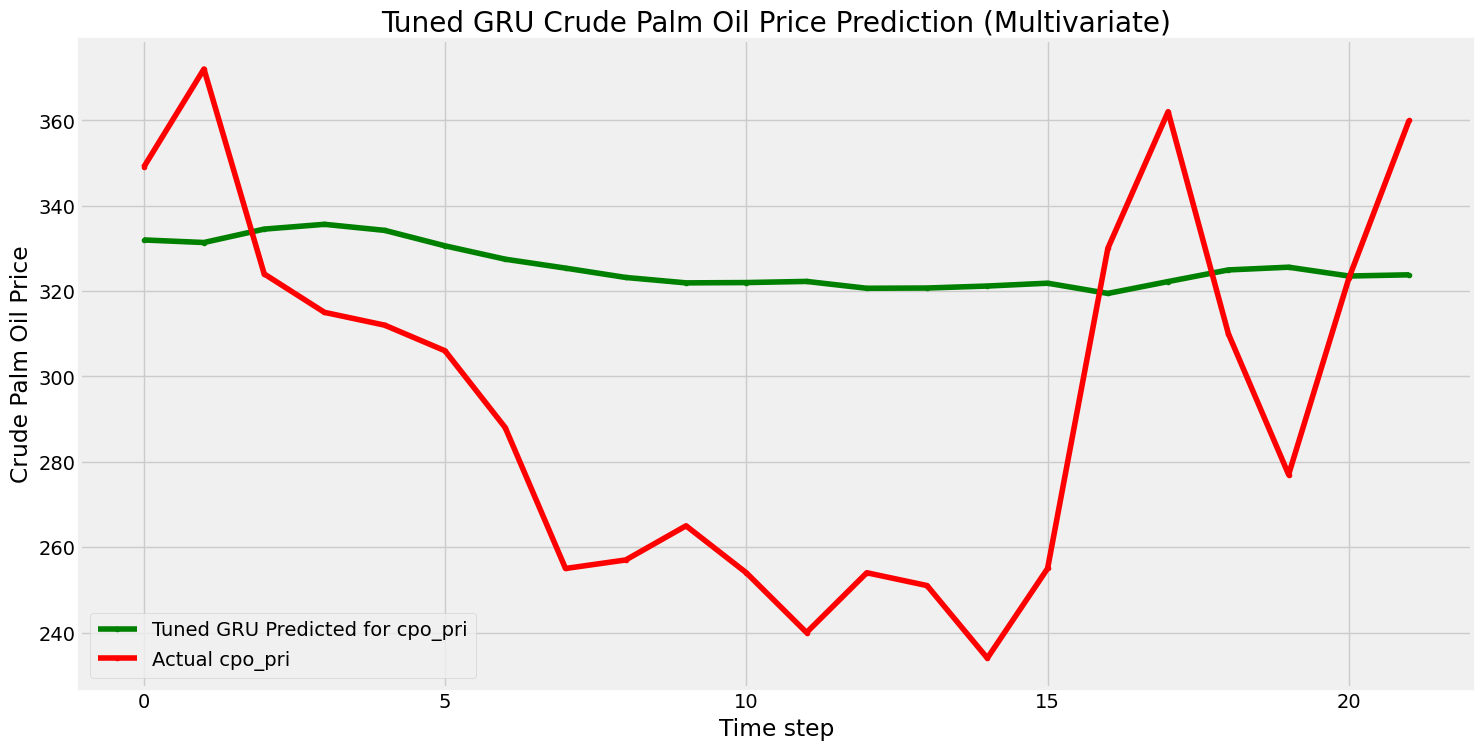

<Figure size 720x360 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
#plt.figure(figsize=(15,7))  #(10,6))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(TU_GRU_Pred, color= 'green',marker='.',label = 'Tuned GRU Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned GRU Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TUGRU.png')

##Results

Baseline MSE         = 0.0160

Random search MSE    = 0.2349

Bayesian search MSE  = 0.3562

Hyperband search MSE = 0.0118

Baseline RSME        = 50.6

Tuned GRU RSME       = 50

The tuned GRU is superior to the basseline based on the RSME result

In [ ]:
TU_GRU_Pred

array([351.39633, 347.6665 , 343.99362, 345.20425, 341.2525 , 337.43933,
       330.63617, 323.23892, 320.77472, 323.42755, 323.79852, 321.35092,
       317.82602, 317.85577, 317.28708, 314.74396, 314.7602 , 318.7627 ,
       322.80365, 325.78122, 317.8231 , 317.70853], dtype=float32)